**AUTHOR:** <br>
Vasilis Raptis

**DATE:** <br>
22.05.2024 

**PURPOSE:** <br>
This notebook: 
- does basic sumstats QC
- censors variant sumstats with <20 observations (AoU policy for exporting data)
- makes manhattan and qq plots for eur, amr, afr sets
- bz compresses files ready to export


**NOTES:** <br>
- AoU dissemination policy: https://support.researchallofus.org/hc/en-us/articles/360043016291-How-to-comply-with-the-All-of-Us-Data-and-Statistics-Dissemination-Policy
- complete this form for approval to download large sumstats files: https://redcap.pmi-ops.org/surveys/?s=YRXMJFJ97J3WMWLE


**Setup:**

In [1]:
# Define the packages to be installed
packages <- c("qqman", "R.utils", "vroom")

# Install packages only if they are not already installed
new_packages <- packages[!(packages %in% installed.packages()[, "Package"])]
if(length(new_packages) > 0) {
  install.packages(new_packages, dependencies = TRUE)
}

# libraries
library(data.table)
library(tidyverse)
library(qqman)
library(stringr)
library(R.utils)
library(vroom)

## Get my bucket name
my_bucket  <- Sys.getenv("WORKSPACE_BUCKET")
## Google project name
GOOGLE_PROJECT <- Sys.getenv("GOOGLE_PROJECT")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

**Load data:**

In [5]:
## copy sumstats to workspace
# system("mkdir -p acaf/eur", intern = T)
# system("mkdir -p acaf/afr", intern = T)
# system("mkdir -p acaf/amr", intern = T)

# system(paste0("gsutil cp -r ", my_bucket, "/data/regenie/step2_acaf/all/eur/chr*", " acaf/eur/"), intern = T)
# system(paste0("gsutil cp -r ", my_bucket, "/data/regenie/step2_acaf/all/afr/chr*", " acaf/afr/"), intern = T)
# system(paste0("gsutil cp -r ", my_bucket, "/data/regenie/step2_acaf/all/amr/chr*", " acaf/amr/"), intern = T)


character(0)

character(0)

character(0)

character(0)

character(0)

character(0)

In [2]:
## acaf WGS
eur_wgs <- 
    list.files(path="acaf/eur/", pattern="chr.*_delirium_status.regenie") %>% 
    map_df(~fread(paste0("acaf/eur/", .))) %>% 
    mutate(P = 10^(-1*LOG10P)) 

In [13]:
afr_wgs <- 
    list.files(path="acaf/afr/", pattern="chr.*_delirium_status.regenie") %>% 
    map_df(~fread(paste0("acaf/afr/", .))) %>% 
    mutate(P = 10^(-1*LOG10P)) 

In [18]:
amr_wgs <- 
    list.files(path="acaf/amr/", pattern="chr.*_delirium_status.regenie") %>% 
    map_df(~fread(paste0("acaf/amr/", .))) %>% 
    mutate(P = 10^(-1*LOG10P)) 

**QC WGS sumstats:**

In [6]:
## qc and censoring 
eur_wgs_qc <-
eur_wgs %>% 
    #mutate(miss = 1- (N / Nmax)) %>% 
    mutate(mac_cases = ifelse(A1FREQ_CASES <= 0.5, as.integer(2*N_CASES*A1FREQ_CASES), as.integer(2*N_CASES*(1-A1FREQ_CASES)))) %>%
    mutate(mac_control = ifelse(A1FREQ_CONTROLS <= 0.5, as.integer(2*N_CONTROLS*A1FREQ_CONTROLS), as.integer(2*N_CONTROLS*(1-A1FREQ_CONTROLS)))) %>%
    filter(mac_cases > 5 & mac_control > 5) %>%
    # for exporting: n > 20 cases and controls
    filter(N_CASES > 20 & N_CONTROLS > 20) %>%
    # for exporting: censor MAC < 40 to -9
    mutate(mac_cases = ifelse(mac_cases < 40, -9, mac_cases),
           mac_control = ifelse(mac_control < 40, -9, mac_control)) %>%
    # exclude crap
    select(-c("INFO","EXTRA","TEST"))#, "mac_cases", "mac_control"))


cat("EUR:")
nrow(eur_wgs)
nrow(eur_wgs_qc)
head(eur_wgs_qc)

EUR:

[1] 45870127

[1] 14364310

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,A1FREQ_CASES,A1FREQ_CONTROLS,N,N_CASES,N_CONTROLS,BETA,SE,CHISQ,LOG10P,P,mac_cases,mac_control
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10167,chr1:10167:CCTAACCCTAA:C,CCTAACCCTAA,C,0.54835700,0.5833330,0.54809200,3195,24,3171,1.019190,0.774309,1.732540,0.725642,0.188086662,-9,2866
1,10194,chr1:10194:A:AC,A,AC,0.50394100,0.5194170,0.50383500,15225,103,15122,1.042690,0.569821,3.348390,1.172170,0.067271328,99,15006
1,10403,chr1:10403:A:AC,A,AC,0.15030000,0.2300000,0.14981900,8330,50,8280,0.731149,0.307072,5.669330,1.762860,0.017263943,-9,2481
1,10403,chr1:10403:ACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC:A,ACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC,A,0.35294100,0.2700000,0.35344200,8330,50,8280,-0.748543,0.291011,6.616270,1.995460,0.010105086,-9,5852
1,10416,chr1:10416:CCCTAA:C,CCCTAA,C,0.00901795,0.0111607,0.00900641,83611,448,83163,0.252524,0.358589,0.495919,0.317585,0.481299045,-9,1498
1,10421,chr1:10421:A:AC,A,AC,0.05440990,0.0909091,0.05422050,36225,187,36038,0.536466,0.196124,7.482130,2.205410,0.006231463,-9,3907


In [14]:
afr_wgs_qc <-
afr_wgs %>% 
    #mutate(miss = 1- (N / Nmax)) %>% 
    mutate(mac_cases = ifelse(A1FREQ_CASES <= 0.5, as.integer(2*N_CASES*A1FREQ_CASES), as.integer(2*N_CASES*(1-A1FREQ_CASES)))) %>%
    mutate(mac_control = ifelse(A1FREQ_CONTROLS <= 0.5, as.integer(2*N_CONTROLS*A1FREQ_CONTROLS), as.integer(2*N_CONTROLS*(1-A1FREQ_CONTROLS)))) %>%
    filter(mac_cases > 5 & mac_control > 5) %>%
    # for exporting: n > 20 cases and controls
    filter(N_CASES > 20 & N_CONTROLS > 20) %>%
    # for exporting: censor MAC < 40 to -9
    mutate(mac_cases = ifelse(mac_cases < 40, -9, mac_cases),
           mac_control = ifelse(mac_control < 40, -9, mac_control)) %>%
    # exclude crap
    select(-c("INFO","EXTRA","TEST", "mac_cases", "mac_control"))

cat("AFR:")
nrow(afr_wgs)
nrow(afr_wgs_qc)
head(afr_wgs_qc)

AFR:

[1] 53837496

[1] 18732517

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,A1FREQ_CASES,A1FREQ_CONTROLS,N,N_CASES,N_CONTROLS,BETA,SE,CHISQ,LOG10P,P
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10786,chr1:10786:C:T,C,T,0.1097190,0.1000000,0.1097550,9579,35,9544,-0.0069808,0.373701,0.000348948,0.00652133,0.9850963
1,10815,chr1:10815:T:TC,T,TC,0.7354920,0.7166670,0.7355680,29897,120,29777,-0.1250210,0.171825,0.529406000,0.33081600,0.4668571
1,10816,chr1:10816:C:CCA,C,CCA,0.6081920,0.6385540,0.6080440,17164,83,17081,0.3315150,0.245306,1.826380000,0.75311700,0.1765562
1,11065,chr1:11065:G:GA,G,GA,0.3603020,0.3400000,0.3604040,4975,25,4950,-0.0320259,0.240911,0.017672200,0.04854430,0.8942433
1,11072,chr1:11072:GGGA:G,GGGA,G,0.4038760,0.4166670,0.4037890,4437,30,4407,0.0119215,0.234918,0.002575290,0.01794290,0.9595268
1,12693,chr1:12693:C:A,C,A,0.0402529,0.0283019,0.0403059,35985,159,35826,-0.3679260,0.286034,1.654580000,0.70259500,0.1983376


In [19]:
amr_wgs_qc <-
amr_wgs %>% 
    #mutate(miss = 1- (N / Nmax)) %>% 
    mutate(mac_cases = ifelse(A1FREQ_CASES <= 0.5, as.integer(2*N_CASES*A1FREQ_CASES), as.integer(2*N_CASES*(1-A1FREQ_CASES)))) %>%
    mutate(mac_control = ifelse(A1FREQ_CONTROLS <= 0.5, as.integer(2*N_CONTROLS*A1FREQ_CONTROLS), as.integer(2*N_CONTROLS*(1-A1FREQ_CONTROLS)))) %>%
    filter(mac_cases > 5 & mac_control > 5) %>%
    # for exporting: n > 20 cases and controls
    filter(N_CASES > 20 & N_CONTROLS > 20) %>%
    # for exporting: censor MAC < 40 to -9
    mutate(mac_cases = ifelse(mac_cases < 40, -9, mac_cases),
           mac_control = ifelse(mac_control < 40, -9, mac_control)) %>%
    # exclude crap
    select(-c("INFO","EXTRA","TEST", "mac_cases", "mac_control"))


cat("AMR:")
nrow(amr_wgs)
nrow(amr_wgs_qc)

AMR:

[1] 52272326

[1] 10625495

**Save QCed sumstats:**

In [9]:
# save per chromosome
system("mkdir -p acaf/eur/for_export/", intern=T)
system("rm acaf/eur/for_export/*", intern=T)

for (chr in seq(1,23)) {
    file <- eur_wgs_qc[eur_wgs_qc$CHROM==chr,]
    filename <- paste0("acaf/eur/for_export/", "aou_eur_delirium_chr", chr, ".regenie")
    write.table(file, filename, sep=" ", quote=F, row.names=F, col.names=T)
    system(paste0("bzip2 -9 ", filename), intern=T)
}

character(0)

character(0)

In [15]:
system("mkdir -p acaf/afr/for_export/", intern=T)
for (chr in seq(1,23)) {
    file <- afr_wgs_qc[afr_wgs_qc$CHROM==chr,]
    filename <- paste0("acaf/afr/for_export/", "aou_afr_delirium_chr", chr, ".regenie")
    write.table(file, filename, sep=" ", quote=F, row.names=F, col.names=T)
    system(paste0("bzip2 -9 ", filename), intern=T)
}

character(0)

In [20]:
system("mkdir -p acaf/amr/for_export/", intern=T)
for (chr in seq(1,23)) {
    file <- amr_wgs_qc[amr_wgs_qc$CHROM==chr,]
    filename <- paste0("acaf/amr/for_export/", "aou_amr_delirium_chr", chr, ".regenie")
    write.table(file, filename, sep=" ", quote=F, row.names=F, col.names=T)
    system(paste0("bzip2 ", filename), intern=T)
}

character(0)

**APOE:**

In [5]:
# ## proxies for rs7412 
# amr %>% filter(CHROM==19 & (GENPOS=="44923535"| GENPOS=="44921921" | GENPOS=="44911142")) %>% head
# ## proxies for rs429358 
# eur %>% filter(CHROM==19 & (GENPOS=="44923535"| GENPOS=="44921921" | GENPOS=="44911142")) %>% head


In [13]:
cat("EUR:")
eur_wgs %>% filter(CHROM==19 & (GENPOS=="44908684" | GENPOS=="44819414"))
#cat("AFR:")
#afr_wgs %>% filter(CHROM==19 & GENPOS=="44908684")
cat("AMR:")
amr_wgs %>% filter(CHROM==19 & (GENPOS=="44908684" | GENPOS=="44819414"))
 


CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,A1FREQ_CASES,A1FREQ_CONTROLS,INFO,N,N_CASES,N_CONTROLS,TEST,BETA,SE,CHISQ,LOG10P,EXTRA,P
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
19,44819414,chr19:44819414:C:T,C,T,0.0018126,0.00306748,0.00168712,1,7172,652,6520,ADD,0.925191,0.7230460,1.63731,0.697464,NA,0.200694745
19,44908684,chr19:44908684:T:C,T,C,0.1395710,0.16411000,0.13711700,1,7172,652,6520,ADD,0.226813,0.0831243,7.44523,2.196510,NA,0.006360482


AMR:

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,A1FREQ_CASES,A1FREQ_CONTROLS,INFO,N,N_CASES,N_CONTROLS,TEST,BETA,SE,CHISQ,LOG10P,EXTRA,P
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
19,44908684,chr19:44908684:T:C,T,C,0.111111,0.0940171,0.112821,1,1287,117,1170,ADD,-0.0901091,0.241387,0.13935,0.149398,NA,0.7089278


**Manhattan plots:**

WGS ACAF:

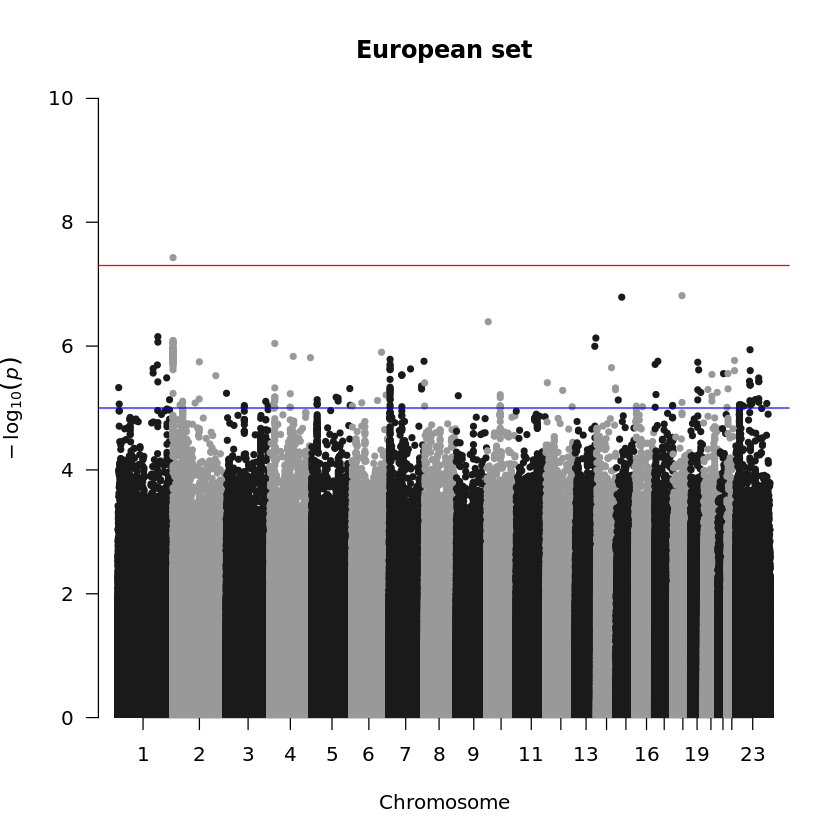

In [10]:
# eur
#manhattan(eur_wgs, chr="CHROM", bp="GENPOS", p="P", snp="ID", logp=T, ylim=c(0,10), main="European set - no QC")
manhattan(eur_wgs_qc, chr="CHROM", bp="GENPOS", p="P", snp="ID", logp=T, ylim=c(0,10), main="European set")


In [ ]:
manhattan(amr_wgs, chr="CHROM", bp="GENPOS", p="P", snp="ID", logp=T, ylim=c(0,10), main="American set - no QC")


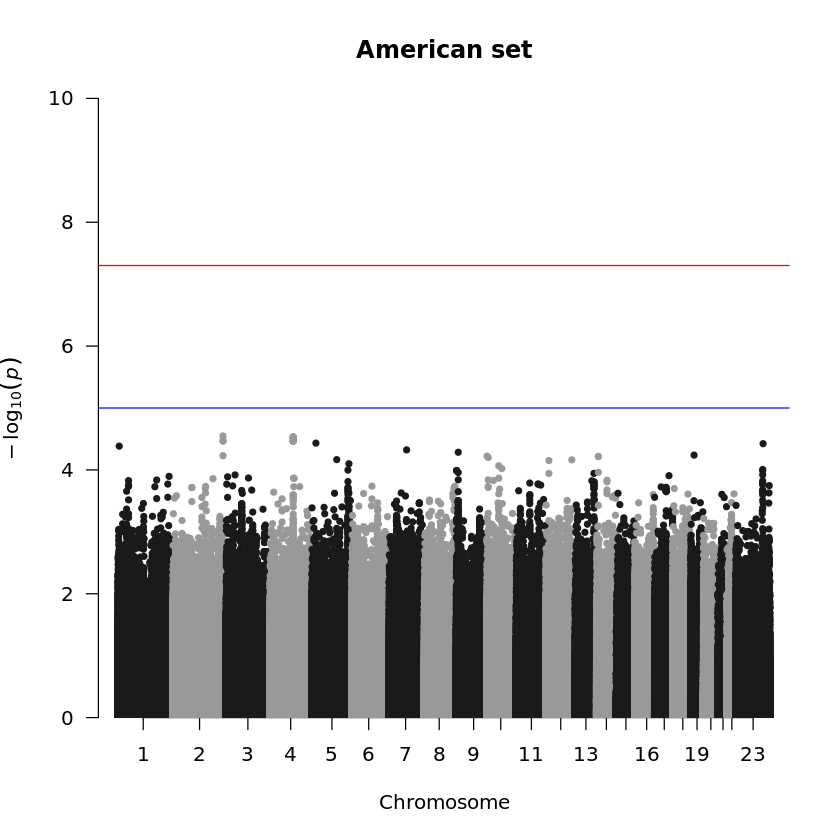

In [5]:
manhattan(amr_wgs_qc, chr="CHROM", bp="GENPOS", p="P", snp="ID", logp=T, ylim=c(0,10), main="American set")


In [ ]:
manhattan(afr_wgs, chr="CHROM", bp="GENPOS", p="P", snp="ID", logp=T, ylim=c(0,10), main="African set - no QC")


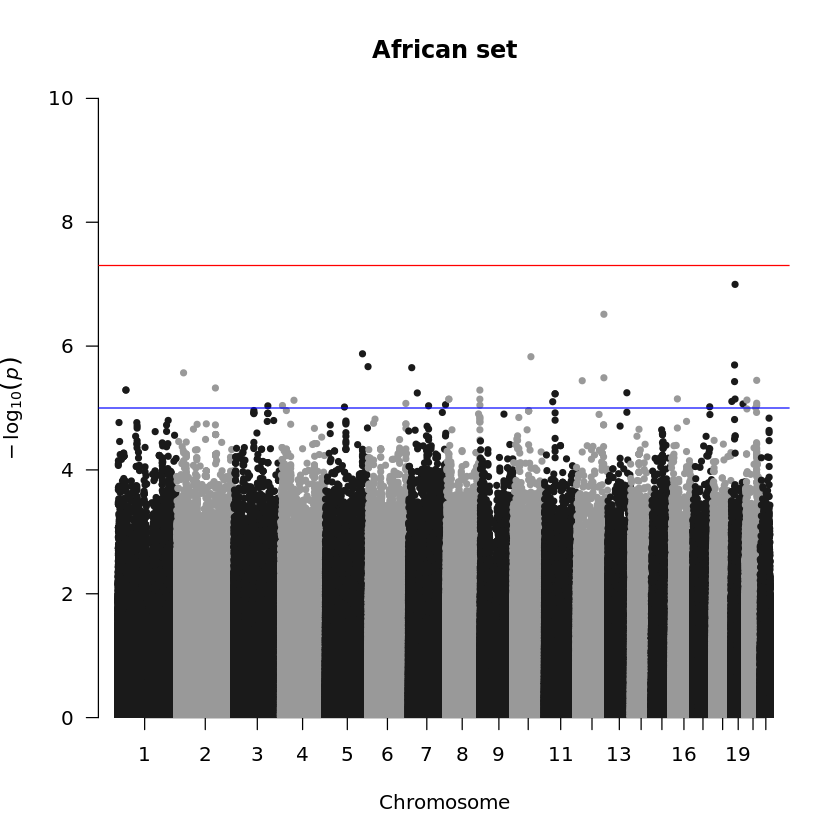

In [7]:
manhattan(afr_wgs_qc, chr="CHROM", bp="GENPOS", p="P", snp="ID", logp=T, ylim=c(0,10), main="African set")

Array SNPs:

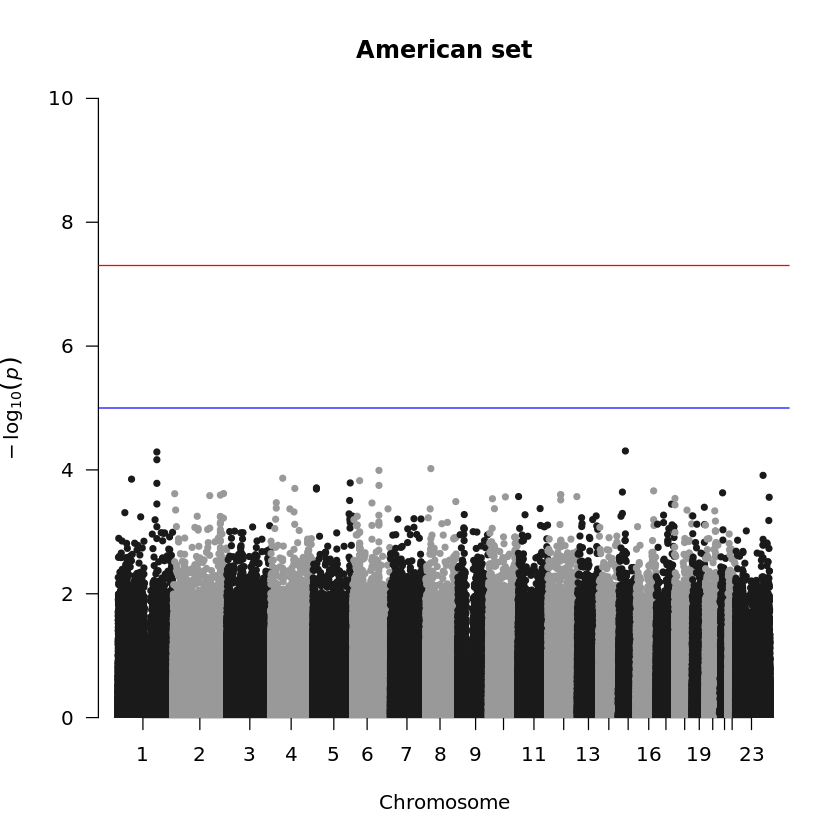

In [15]:
# amr
manhattan(amr, chr="CHROM", bp="GENPOS", p="P", snp="ID", logp=T, ylim=c(0,10), main="American set")

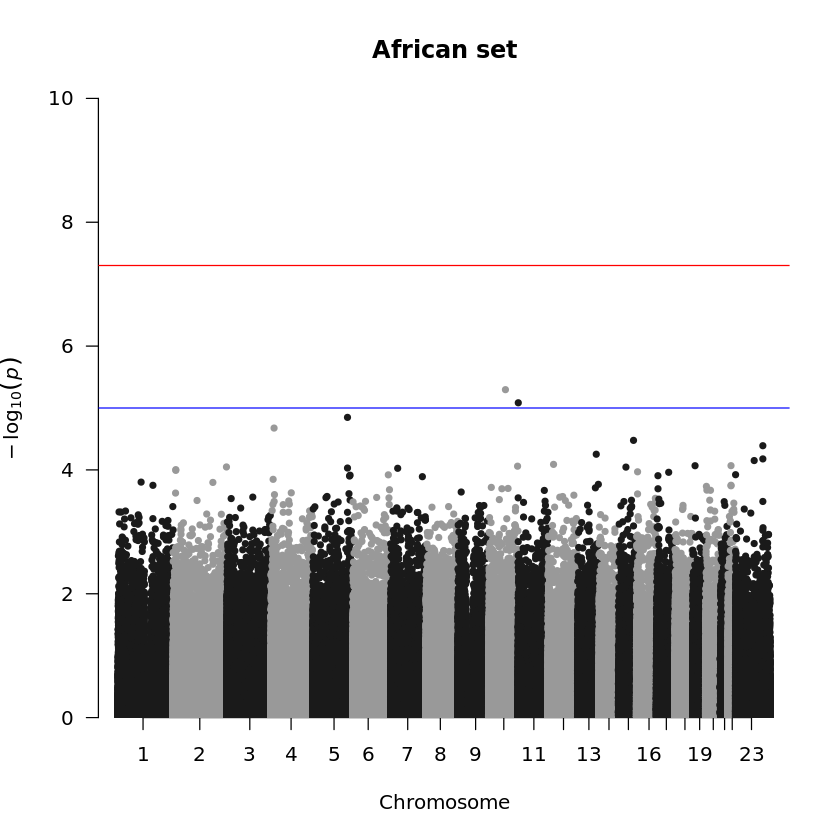

In [8]:
#afr
manhattan(afr, chr="CHROM", bp="GENPOS", p="P", snp="ID", logp=T, ylim=c(0,10), main="African set")


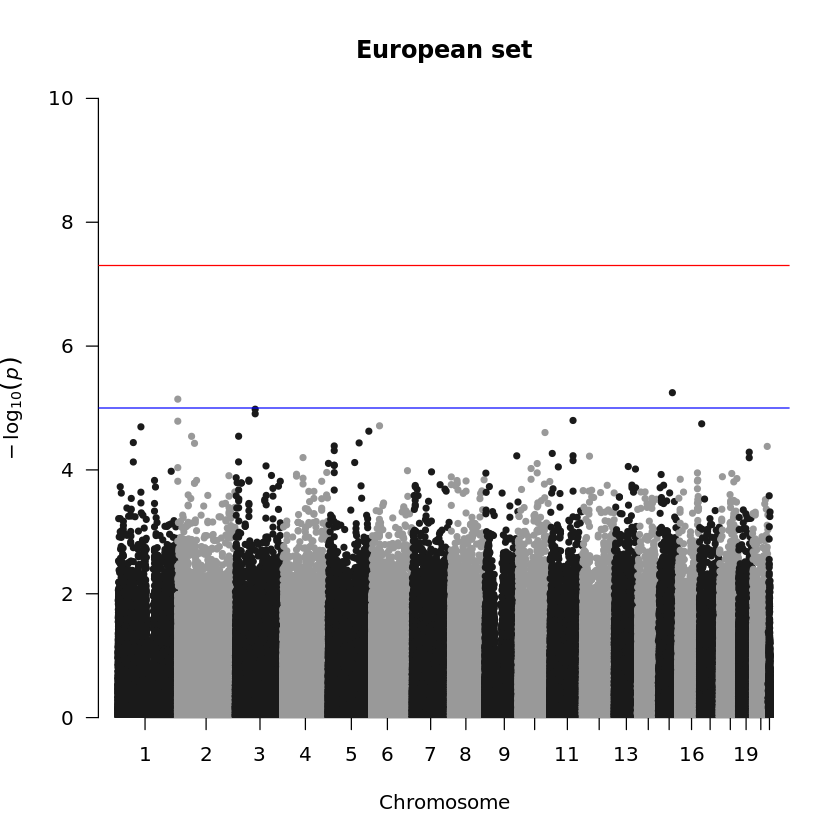

In [5]:
# eur
manhattan(eur, chr="CHROM", bp="GENPOS", p="P", snp="ID", logp=T, ylim=c(0,10), main="European set")


Clinvar SNPs:

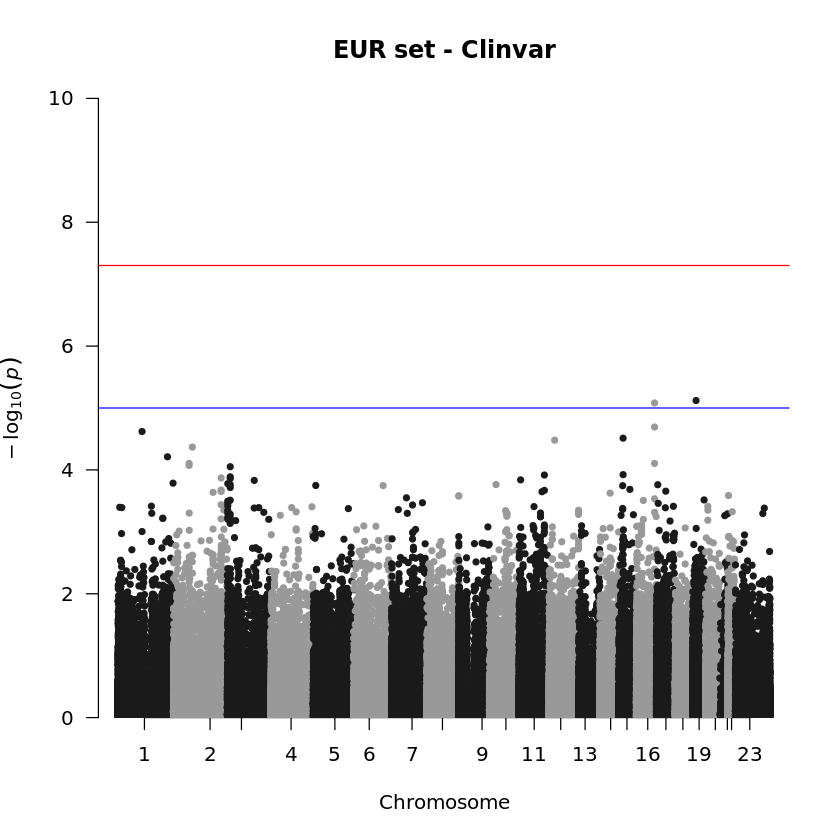

In [5]:
# eur
manhattan(eur_clinvar, chr="CHROM", bp="GENPOS", p="P", snp="ID", logp=T, ylim=c(0,10), main="EUR set - Clinvar")

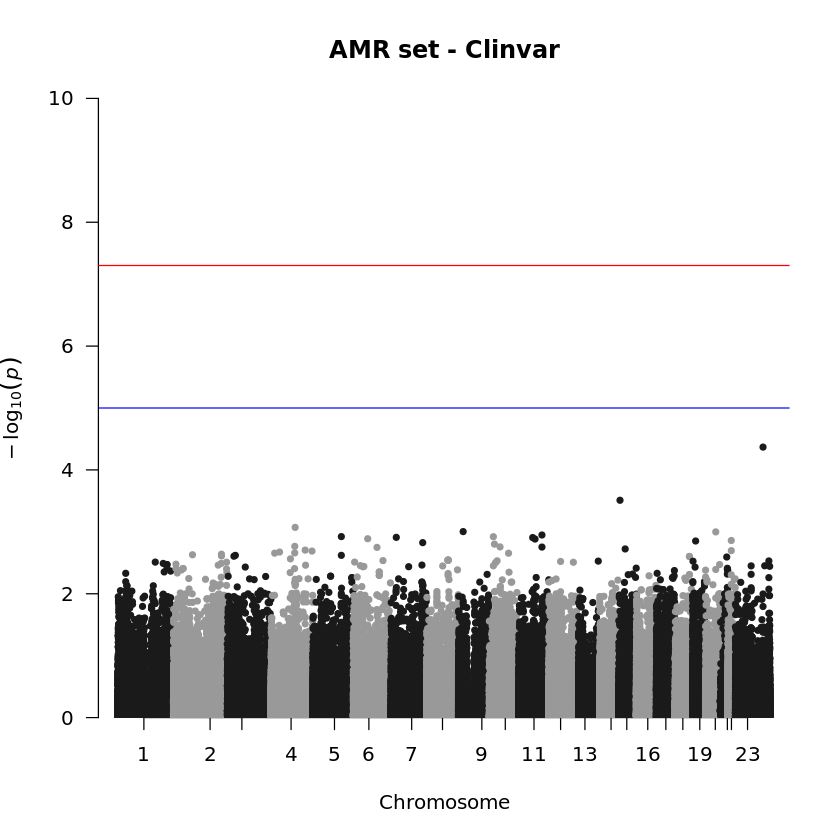

In [4]:
# amr
manhattan(amr_clinvar, chr="CHROM", bp="GENPOS", p="P", snp="ID", logp=T, ylim=c(0,10), main="AMR set - Clinvar")

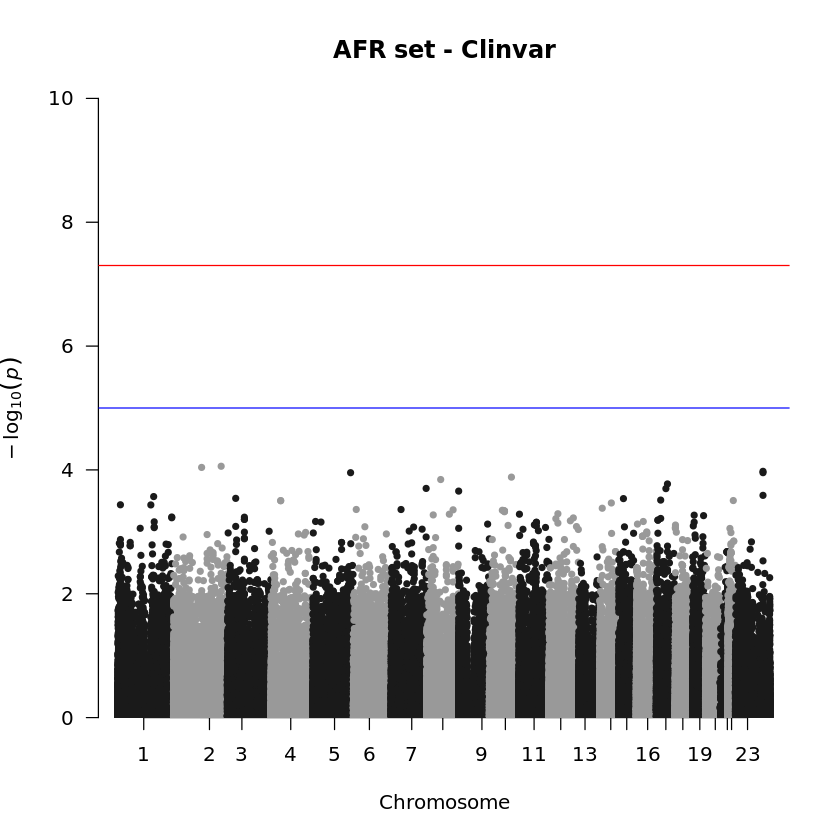

In [17]:
# afr
manhattan(afr_clinvar, chr="CHROM", bp="GENPOS", p="P", snp="ID", logp=T, ylim=c(0,10), main="AFR set - Clinvar")

**APOE sumstats:**

In [17]:
# apoe
cat("EUR:")
eur_clinvar %>% filter(CHROM==19 & GENPOS=="44908684")
eur_wgs %>% filter(CHROM==19 & GENPOS=="44908684")
#eur_clinvar1on5 %>% filter(CHROM==19 & GENPOS=="44908684")
#eur_clinvar %>% arrange(P)
cat("AMR:")
amr_clinvar %>% filter(CHROM==19 & GENPOS=="44908684")
cat("AFR:")
afr_clinvar %>% filter(CHROM==19 & GENPOS=="44908684")


EUR:

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,P
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,44908684,chr19:44908684:T:C,C,T,0.860429,1,7172,ADD,-0.226596,0.0831014,7.43513,2.19407,0.006396317


CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,A1FREQ_CASES,A1FREQ_CONTROLS,INFO,N,N_CASES,N_CONTROLS,TEST,BETA,SE,CHISQ,LOG10P,EXTRA,P
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
19,44908684,chr19:44908684:T:C,T,C,0.139571,0.16411,0.137117,1,7172,652,6520,ADD,0.226813,0.0831243,7.44523,2.19651,NA,0.006360482


AMR:

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,P
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,44908684,chr19:44908684:T:C,C,T,0.888889,1,1287,ADD,0.0901091,0.241387,0.13935,0.149398,0.7089278


AFR:

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,P
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,44908684,chr19:44908684:T:C,C,T,0.788919,1,2563,ADD,-0.164917,0.124634,1.7509,0.731038,0.1857642


In [ ]:
# wgs
cat("EUR:")
eur_wgs %>% filter(CHROM==19 & GENPOS=="44908684")


In [22]:
# near apoe
cat("EUR:")
eur_clinvar %>% filter(CHROM==19 & GENPOS=="44906745")
#eur_clinvar1on5 %>% filter(CHROM==19 & GENPOS=="44908684")
#eur_clinvar %>% arrange(P)
cat("AMR:")
amr_clinvar %>% filter(CHROM==19 & GENPOS=="44906745")
cat("AFR:")
afr_clinvar %>% filter(CHROM==19 & GENPOS=="44906745")


EUR:

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,P
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,44906745,chr19:44906745:G:A,A,G,0.886192,1,7170,ADD,-0.273596,0.0898516,9.27191,2.63321,0.002326966


AMR:

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,P
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,44906745,chr19:44906745:G:A,A,G,0.932401,1,1287,ADD,0.106439,0.314064,0.114858,0.133902,0.7346796


AFR:

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,INFO,N,TEST,BETA,SE,CHISQ,LOG10P,P
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19,44906745,chr19:44906745:G:A,A,G,0.979126,1,2563,ADD,-0.326495,0.363009,0.808942,0.433641,0.3684334


In [8]:
## wgs
afr_wgs_qc %>% arrange(P)

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,A1FREQ_CASES,A1FREQ_CONTROLS,INFO,N,⋯,N_CONTROLS,TEST,BETA,SE,CHISQ,LOG10P,EXTRA,P,mac_cases,mac_control
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,⋯,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>
19,16278477,chr19:16278477:T:C,T,C,0.01526420,0.0493562,0.01184320,1,2555,⋯,2322,ADD,1.556650,0.292314,28.3585,6.99652,NA,1.008045e-07,22,54
12,116871067,chr12:116871067:C:T,C,T,0.09052250,0.0246637,0.09706140,1,2469,⋯,2246,ADD,-1.174850,0.229479,26.2105,6.51406,NA,3.061540e-07,11,435
5,157129394,chr5:157129394:C:CAA,C,CAA,0.07220430,0.1355560,0.06590000,1,2486,⋯,2261,ADD,0.788331,0.163052,23.3757,5.87534,NA,1.332478e-06,61,297
10,76287365,chr10:76287365:A:G,A,G,0.03082330,0.0729614,0.02660940,1,2563,⋯,2330,ADD,1.117010,0.232067,23.1680,5.82843,NA,1.484465e-06,34,123
19,14201417,chr19:14201417:ATT:A,ATT,A,0.16419100,0.0815451,0.17247300,1,2558,⋯,2325,ADD,-0.717474,0.150998,22.5773,5.69496,NA,2.018552e-06,38,801
5,180634858,chr5:180634858:ATGGGTGGATG:A,ATGGGTGGATG,A,0.02887320,0.1044780,0.02099530,1,710,⋯,643,ADD,1.874160,0.395484,22.4571,5.66778,NA,2.148919e-06,14,26
7,13785284,chr7:13785284:TA:T,TA,T,0.10208100,0.0380117,0.10889900,1,1778,⋯,1607,ADD,-1.138930,0.240731,22.3836,5.65117,NA,2.232698e-06,13,350
2,29187692,chr2:29187692:T:C,T,C,0.00468201,0.0214592,0.00300429,1,2563,⋯,2330,ADD,2.274210,0.484693,22.0154,5.56787,NA,2.704768e-06,9,13
12,116879399,chr12:116879399:T:G,T,G,0.09793210,0.0364807,0.10407700,1,2563,⋯,2330,ADD,-0.963204,0.206949,21.6625,5.48800,NA,3.250873e-06,17,484


**MTAG replication:**

In [4]:
# load mtag lead variants
mtag <- fread("del_MTAG_sumstats.csv", drop = 1) %>% mutate(ID = paste0(CHR, ":", POS))
mtag %>% head

SNPID,rsID,CHR,POS,EA,NEA,EAF,BETA,SE,P,N,STATUS,LOCATION,GENE,ID
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<chr>
1:207633385:A:G,rs6697005,1,207633385,A,G,0.8144,-0.012539963,0.001856628,1.436644e-11,751972,3899999,0,CR1,1:207633385
2:127135234:T:C,rs6733839,2,127135234,T,C,0.3862,0.017798790,0.001482563,3.327749e-33,751972,3899999,-27946,BIN1,2:127135234
6:41161514:T:C,rs75932628,6,41161514,T,C,0.0026,0.105648302,0.014207393,1.036621e-13,751972,3899999,0,TREM2,6:41161514
7:100179799:A:G,rs55796551,7,100179799,A,G,0.2488,-0.009697624,0.001669667,6.317824e-09,751972,3899999,0,STAG3,7:100179799
8:27610169:T:C,rs9331896,8,27610169,T,C,0.5863,0.009283066,0.001465649,2.392618e-10,751972,3899999,0,CLU,8:27610169
11:60254475:A:G,rs1582763,11,60254475,A,G,0.3543,-0.009993381,0.001509148,3.546813e-11,751972,3899999,0,MS4A4A,11:60254475


In [22]:
left_join(mtag, eur_wgs_qc, by = c("CHR"="CHROM", "POS"="GENPOS", "EA"="ALLELE1", "NEA"="ALLELE0"))

SNPID,rsID,CHR,POS,EA,NEA,EAF,BETA.x,SE.x,P.x,⋯,N_CONTROLS,TEST,BETA.y,SE.y,CHISQ,LOG10P,EXTRA,P.y,mac_cases,mac_control
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>
1:207633385:A:G,rs6697005,1,207633385,A,G,0.8144,-0.012539963,0.001856628,1.436644e-11,⋯,6520,ADD,-0.09965700,0.0761637,1.71206000,0.7196080,NA,0.1907181,270,2513
2:127135234:T:C,rs6733839,2,127135234,T,C,0.3862,0.017798790,0.001482563,3.327749e-33,⋯,6520,ADD,-0.06647380,0.0614297,1.17096000,0.5540800,NA,0.2792029,492,5087
6:41161514:T:C,rs75932628,6,41161514,T,C,0.0026,0.105648302,0.014207393,1.036621e-13,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7:100179799:A:G,rs55796551,7,100179799,A,G,0.2488,-0.009697624,0.001669667,6.317824e-09,⋯,6520,ADD,-0.00599814,0.0712499,0.00708704,0.0301604,NA,0.9329097,300,2963
8:27610169:T:C,rs9331896,8,27610169,T,C,0.5863,0.009283066,0.001465649,2.392618e-10,⋯,6519,ADD,-0.00724651,0.0627007,0.01335710,0.0419185,NA,0.9079909,531,5328
11:60254475:A:G,rs1582763,11,60254475,A,G,0.3543,-0.009993381,0.001509148,3.546813e-11,⋯,6520,ADD,-0.07525150,0.0626501,1.44274000,0.6388450,NA,0.2296968,478,4936
11:86139201:T:C,rs3844143,11,86139201,T,C,0.4680,0.010657366,0.001446618,1.743949e-13,⋯,6520,ADD,-0.03866560,0.0607819,0.40467100,0.2801000,NA,0.5246866,648,6387
12:113128128:A:G,rs34598602,12,113128128,A,G,0.0777,0.014704993,0.002696411,4.937611e-08,⋯,6520,ADD,0.17212000,0.1177540,2.13653000,0.8421590,NA,0.1438272,103,872
15:63277703:T:C,rs117618017,15,63277703,T,C,0.1350,0.014227521,0.002112311,1.633394e-11,⋯,6519,ADD,-0.14491700,0.0915672,2.50470000,0.9449780,NA,0.1135068,151,1761


In [5]:
left_join(mtag, afr_wgs, by = c("CHR"="CHROM", "POS"="GENPOS", "EA"="ALLELE1", "NEA"="ALLELE0"))

SNPID,rsID,CHR,POS,EA,NEA,EAF,BETA.x,SE.x,P.x,⋯,N.y,N_CASES,N_CONTROLS,TEST,BETA.y,SE.y,CHISQ,LOG10P,EXTRA,P.y
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1:207633385:A:G,rs6697005,1,207633385,A,G,0.8144,-0.012539963,0.001856628,1.436644e-11,⋯,2563,233,2330,ADD,-0.0088487,0.172181,0.00264113,0.0181754,NA,0.9590132
2:127135234:T:C,rs6733839,2,127135234,T,C,0.3862,0.017798790,0.001482563,3.327749e-33,⋯,2563,233,2330,ADD,0.1392840,0.103594,1.80773000,0.7476780,NA,0.1787813
6:41161514:T:C,rs75932628,6,41161514,T,C,0.0026,0.105648302,0.014207393,1.036621e-13,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7:100179799:A:G,rs55796551,7,100179799,A,G,0.2488,-0.009697624,0.001669667,6.317824e-09,⋯,2563,233,2330,ADD,-0.0378375,0.110895,0.11641900,0.1349250,NA,0.7329511
8:27610169:T:C,rs9331896,8,27610169,T,C,0.5863,0.009283066,0.001465649,2.392618e-10,⋯,2563,233,2330,ADD,-0.0604110,0.102272,0.34891300,0.2559190,NA,0.5547292
11:60254475:A:G,rs1582763,11,60254475,A,G,0.3543,-0.009993381,0.001509148,3.546813e-11,⋯,2563,233,2330,ADD,0.0122716,0.187722,0.00427336,0.0232473,NA,0.9478786
11:86139201:T:C,rs3844143,11,86139201,T,C,0.4680,0.010657366,0.001446618,1.743949e-13,⋯,2562,233,2329,ADD,-0.1577360,0.106104,2.21002000,0.8629100,NA,0.1371166
12:113128128:A:G,rs34598602,12,113128128,A,G,0.0777,0.014704993,0.002696411,4.937611e-08,⋯,2563,233,2330,ADD,-0.7347460,0.477417,2.36853000,0.9072670,NA,0.1238035
15:63277703:T:C,rs117618017,15,63277703,T,C,0.1350,0.014227521,0.002112311,1.633394e-11,⋯,2563,233,2330,ADD,-0.2959280,0.333161,0.78897500,0.4266520,NA,0.3744105


In [9]:
left_join(mtag, amr_wgs, by = c("CHR"="CHROM", "POS"="GENPOS", "EA"="ALLELE1", "NEA"="ALLELE0"))

SNPID,rsID,CHR,POS,EA,NEA,EAF,BETA.x,SE.x,P.x,⋯,N.y,N_CASES,N_CONTROLS,TEST,BETA.y,SE.y,CHISQ,LOG10P,EXTRA,P.y
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1:207633385:A:G,rs6697005,1,207633385,A,G,0.8144,-0.012539963,0.001856628,1.436644e-11,⋯,1287,117,1170,ADD,0.0688849,0.242139,0.08093150,0.1101160,NA,0.77603981
2:127135234:T:C,rs6733839,2,127135234,T,C,0.3862,0.017798790,0.001482563,3.327749e-33,⋯,1287,117,1170,ADD,-0.0757766,0.148234,0.26132000,0.2152290,NA,0.60921558
6:41161514:T:C,rs75932628,6,41161514,T,C,0.0026,0.105648302,0.014207393,1.036621e-13,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7:100179799:A:G,rs55796551,7,100179799,A,G,0.2488,-0.009697624,0.001669667,6.317824e-09,⋯,1287,117,1170,ADD,-0.0624023,0.164220,0.14439400,0.1524570,NA,0.70395192
8:27610169:T:C,rs9331896,8,27610169,T,C,0.5863,0.009283066,0.001465649,2.392618e-10,⋯,1287,117,1170,ADD,-0.0115521,0.155053,0.00555092,0.0265909,NA,0.94060894
11:60254475:A:G,rs1582763,11,60254475,A,G,0.3543,-0.009993381,0.001509148,3.546813e-11,⋯,1287,117,1170,ADD,0.0201185,0.154239,0.01701380,0.0475850,NA,0.89622076
11:86139201:T:C,rs3844143,11,86139201,T,C,0.4680,0.010657366,0.001446618,1.743949e-13,⋯,1287,117,1170,ADD,-0.2913690,0.149680,3.78931000,1.2875100,NA,0.05158103
12:113128128:A:G,rs34598602,12,113128128,A,G,0.0777,0.014704993,0.002696411,4.937611e-08,⋯,1287,117,1170,ADD,-0.2512810,0.328368,0.58559300,0.3524910,NA,0.44412887
15:63277703:T:C,rs117618017,15,63277703,T,C,0.1350,0.014227521,0.002112311,1.633394e-11,⋯,1287,117,1170,ADD,-0.4686420,0.271575,2.97786000,1.0736000,NA,0.08441119


**Top AoU hits:**


In [11]:
afr_wgs %>% filter(CHROM==19 & GENPOS==44819414)

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,A1FREQ_CASES,A1FREQ_CONTROLS,INFO,N,N_CASES,N_CONTROLS,TEST,BETA,SE,CHISQ,LOG10P,EXTRA,P
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>


In [14]:
eur_wgs %>% filter(CHROM==19 & GENPOS==44819414)

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,A1FREQ_CASES,A1FREQ_CONTROLS,INFO,N,N_CASES,N_CONTROLS,TEST,BETA,SE,CHISQ,LOG10P,EXTRA,P
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
19,44819414,chr19:44819414:C:T,C,T,0.0018126,0.00306748,0.00168712,1,7172,652,6520,ADD,0.925191,0.723046,1.63731,0.697464,NA,0.2006947


In [15]:
amr_wgs %>% filter(CHROM==19 & GENPOS==44819414)

CHROM,GENPOS,ID,ALLELE0,ALLELE1,A1FREQ,A1FREQ_CASES,A1FREQ_CONTROLS,INFO,N,N_CASES,N_CONTROLS,TEST,BETA,SE,CHISQ,LOG10P,EXTRA,P
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>
